## How To Create Custom Kernel Loss Functions

In this guide, we show how to create custom kernel loss functions for quantum kernel training. This is useful if we desire the resulting kernel exhibit certain properties such as low rank, or high generalization to unseen data when used for classification. For this purpose, one may wish to evaluate a kernel on some dataset, $X$, and compute properties of the resulting kernel matrix, $K$, or optimize quantities related to the model weights of a [Support Vector Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) that has been trained using $K$. 

In order to ensure compatibility with Qiskit's optimizers, it is neccesary that kernel loss functions follow the following input-output behavior:

- A kernel loss function must take as input a single array of trainable parameter values 
- A kernel loss function must return a real number

Despite these constraints, the data, labels, `TrainableFidelityQuantumKernel` object, and any other necessary inputs must be made available to the kernel loss's internal logic. Below we suggest two approaches:

1. Provide all inputs to kernel loss as class variables
2. Wrap kernel loss function using `partial`


In [1]:
# pylint: disable=import-error, wrong-import-position, too-few-public-methods, no-self-use, function-redefined
from functools import partial
from typing import Sequence
import os
import sys

import numpy as np
import matplotlib.pyplot as plt

# Import Qiskit packages
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.utils.loss_functions import KernelLoss

Let's start by setting up a quantum kernel, data, and labels.

In [2]:
feature_map = ZZFeatureMap(3)
user_params = [feature_map.parameters[1]]

qkernel = TrainableFidelityQuantumKernel(
    feature_map=feature_map,
    training_parameters=user_params,
)

X_train = [[0.6, 0.2], [0.5, 0.3], [0.3, 0.7], [0.1, 0.5]]
y_train = np.array([0, 0, 1, 1])

### Option 1: Provide all inputs to kernel loss as class variables

The preferred option for building a custom kernel loss function is to mimic the structure of Qiskit's pre-defined kernel loss functions, such as `SVCLoss`. 

In order to match the behavior of existing kernel loss methods, your class should:
- Extend `KernelLoss` 
- Accept `kwargs` in the constructor
- Include a `evaluate` method that takes all neccesary inputs and returns the evaluated loss
- Include a `get_variational_callable` method that wraps `evaluate` with all inputs except the trainable parameter values `user_param_values`


In [3]:
class CustomKernelLoss(KernelLoss):
    """Example Kernel Loss class"""

    def __init__(self, **kwargs):
        self.kwargs = kwargs

    # Evaluate the Loss of a trainable quantum kernel
    # at a particular setting of user_param_values on
    # a particular dataset.
    def evaluate(
        self,
        parameter_values: Sequence[float],
        quantum_kernel: TrainableFidelityQuantumKernel,
        data: np.ndarray,
        labels: np.ndarray,
    ):
        # Bind the user parameter values
        quantum_kernel.assign_training_parameters(parameter_values)
        kernel_matrix = quantum_kernel.evaluate(data)
        return labels.T @ kernel_matrix @ labels

    # Wrap our evaluate method so to produce a callable
    # which maps user_param_values to loss scores.
    def get_variational_callable(
        self, quantum_kernel: TrainableFidelityQuantumKernel, data: np.ndarray, labels: np.ndarray
    ):
        return partial(
            self.evaluate, quantum_kernel=quantum_kernel, data=data, labels=labels
        )


kernel_loss = CustomKernelLoss().get_variational_callable(qkernel, X_train, y_train)
print(kernel_loss([0.75]))

2.0828564856509986


We now have a black box callable that assigns a numeric value to any set of user parameter bindings. 

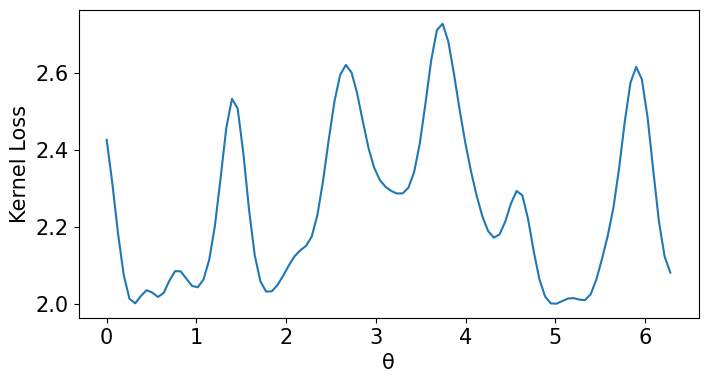

In [4]:
NUM_GRID_POINTS = 100
loss_values = [kernel_loss([val]) for val in np.linspace(0, 2 * np.pi, NUM_GRID_POINTS)]

plt.rcParams["font.size"] = 15
plt.figure(figsize=(8, 4))
plt.plot(np.linspace(0, 2 * np.pi, NUM_GRID_POINTS), loss_values)
plt.xlabel("θ")
plt.ylabel("Kernel Loss")
plt.show()

### Option 2: Define kernel loss as a method and wrap with `partial`
If you do not wish to define a full class for your kernel loss (e.g., to minimize lines of code), you are always free to define your kernel loss as a standalone function that is then wrapped with `partial` to enforce the expected input/output behavior. Note that if your inputs are defined within scope of your kernel loss method, you can actually avoid using `partial`; however, this will often not be feasible in practice. 

In [5]:
def kernel_loss_full(training_param_values, kernel, data, labels):
    kernel.assign_training_parameters(training_param_values)
    kernel_matrix = kernel.evaluate(data)
    return labels.T @ kernel_matrix @ labels


kernel_loss = partial(kernel_loss_full, kernel=qkernel, data=X_train, labels=y_train)
print(kernel_loss([0.75]))

2.0828564856509986


In [6]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright